In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.interpolate import NearestNDInterpolator
%matplotlib inline

- Use algún método de interpolación en una malla regular,Voronoi por ejemplo
- Calcule la Transformada de Fourier de la señal regularmente remuestreada
- descarte las altas frecuencias
- Calcule la Transformada de Fourier inversa para producir el estimado f1
- Calcule el error f (n) − f1 (n), para1, . . . , N
- use este error estimado en cada punto para estimar f2 (n)...
- Itere recalculando la Transformada de Fourier

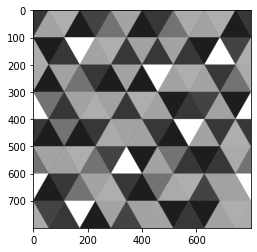

In [2]:
image = cv2.imread('patterns.png',flags=cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap='gray')

In [3]:
H,W = image.shape
print(H,W)

800 800


In [4]:
image[H-1][W-1]

181

In [44]:

# return an array of random points(x,y) where x<=max_width and b<=max_height
def get_random_points(max_height,max_width,quantity):
    points = []
    while len(points)<quantity and len(points)<max_height*max_width:
        x_coord = random.randint(0,max_width-1)
        y_coord = random.randint(0,max_height-1)
        point = (x_coord,y_coord)
        if(point not in points):
            points.append((x_coord,y_coord))
    return points

# returns the irregular sampled image and the points used to evalute the value of the image    
def get_irregular_sampling(image,number_of_points):
    height , width = image.shape
    irregular_sampled_image = np.zeros(shape=(height,width))
    image_values=[]
    random_points = get_random_points(height,width,number_of_points)
    
    for i in range(number_of_points):
        x,y = random_points[i]
        irregular_sampled_image[y][x]=image[y][x]
        image_values.append(image[y][x])
    return irregular_sampled_image,random_points,image_values

def get_points(max_height,max_width):
    points = []
    for i in range(max_height):
        for j in range(max_width):
            points.append((i,j))
    return points

def get_regular_sampling(image):
    height , width = image.shape
    image_values=[]
    r_points = get_points(height,width)
    for i in range(len(r_points)):
        x,y = r_points[i]
        image_values.append(image[y][x])
    return r_points,image_values



def create_interpolated_image(interpolated_func,height,width):
    int_image = np.empty(shape=(height,width))
    for i in range(width):
        for j in range(height):
            int_image[j][i]=interpolated_func((i,j))
    return int_image

def plot_fourier_transform(fft):
    #fshift = np.fft.fftshift(fft)
    magnitude_spectrum = 20*np.log(np.abs(fft))
    plt.imshow(magnitude_spectrum,cmap='gray')
    return magnitude_spectrum ,np.abs(fft)

def plot_inverse_fourier_tranform(ifft):
    i_magnitude_spectrum = 20*np.log(np.abs(ifft))
    plt.imshow(i_magnitude_spectrum,cmap='gray')
    
    return i_magnitude_spectrum , np.abs(ifft)
def circle_img(r,x,y):
    circle_img = np.zeros(shape=(H,W), dtype=np.uint8)
    circle_img = cv2.circle(circle_img, (x,y) , r, (255,255,255), -1)
    return circle_img

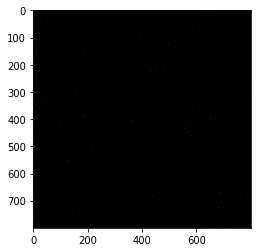

In [32]:
i_sampled_image,i_points,i_values = get_irregular_sampling(image,1000)
plt.imshow(i_sampled_image,cmap='gray')

In [36]:
len(i_points)

1000

In [7]:
interpolation = NearestNDInterpolator(i_points,i_values)

In [38]:
interpolation((200,30.2))

129

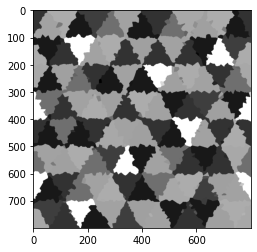

In [39]:
int_image = create_interpolated_image(interpolation,H,W)
plt.imshow(int_image,cmap='gray')

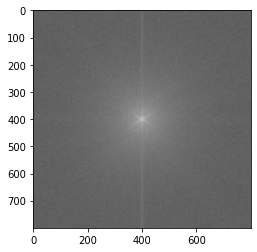

In [10]:
fft= np.fft.fft2(int_image)
magnitude_spectrum , raw_magnitude = plot_fourier_transform(fft)

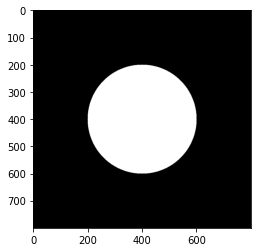

In [11]:
r=H//4
circle = circle_img(r,H//2,W//2)
plt.imshow(circle,cmap='gray')

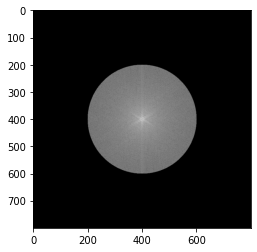

In [12]:
filtered_spectrum = circle*magnitude_spectrum
plt.imshow(filtered_spectrum,cmap='gray')

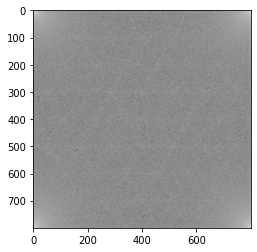

In [13]:
ifft =np.fft.ifft2(filtered_spectrum)
i_magnitude_spectrum,i_raw_magnitude = plot_inverse_fourier_tranform(ifft)


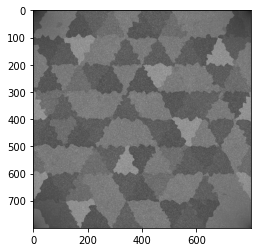

In [14]:
#error = i_sampled_image-i_magnitude_spectrum
error = int_image-i_magnitude_spectrum
plt.imshow(error,cmap='gray')

In [15]:
def reconstruc(f,A,fn):
    return fn + A *(f-fn)

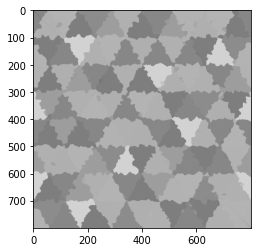

In [16]:
f2=reconstruc(error,np.identity(H),int_image)
plt.imshow(f2,cmap='gray')

In [17]:
int_image.astype(np.uint8)
print(cv2.PSNR(image,f2.astype(np.uint8)))

23.587865471357272


# 2nd

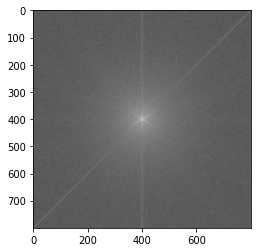

In [18]:
fft= np.fft.fft2(f2)
magnitude_spectrum , raw_magnitude = plot_fourier_transform(fft)

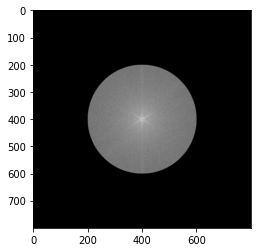

In [19]:
filtered_spectrum = circle*magnitude_spectrum
plt.imshow(filtered_spectrum,cmap='gray')

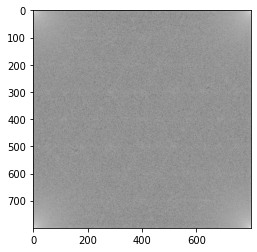

In [20]:
ifft =np.fft.ifft2(filtered_spectrum)
i_magnitude_spectrum,i_raw_magnitude = plot_inverse_fourier_tranform(ifft)

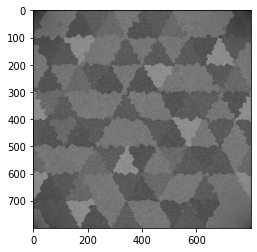

In [21]:
error = int_image-i_magnitude_spectrum
plt.imshow(error,cmap='gray')

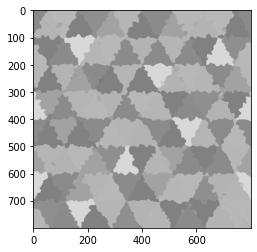

In [22]:
f3=reconstruc(error,np.identity(H),int_image)
plt.imshow(f3,cmap='gray')

In [23]:
int_image.astype(np.uint8)
print(cv2.PSNR(image,f3.astype(np.uint8)))

23.589004945636646


# algo


In [53]:
def reconstruction_img(original_img,iterations,sampling_points):
    H,W = original_img.shape
    i_sampled_image , i_points , i_values = get_irregular_sampling(original_img,sampling_points)
    interpolation = NearestNDInterpolator(i_points,i_values)
    int_image = create_interpolated_image(interpolation,H,W)
    
    reconstructed_images=[]
    prev_psnr = 0
    for i in range (iterations):
        fft= np.fft.fft2(int_image)
        #fshift = np.fft.fftshift(fft)
        magnitude_spectrum = np.abs(fft)
        
        r=H//4
        circle = circle_img(r,H//2,W//2)
        filtered_spectrum = circle*magnitude_spectrum
        
        ifft =np.fft.ifft2(filtered_spectrum)
        i_magnitude_spectrum = np.abs(ifft)
        
        error = int_image - i_magnitude_spectrum
        
        f_i=reconstruc(error,np.identity(H),original_img)
        
        reconstructed_images.append(f_i)
        psnr = cv2.PSNR(original_img,f_i.astype(np.uint8))
        print(psnr, prev_psnr-psnr)
        
        int_image = f_i
        prev_psnr = psnr
    return reconstructed_images
        

In [54]:
og_img = cv2.imread('patterns.png',flags=cv2.IMREAD_GRAYSCALE)
iterations = 10
sampling_points = 5000
rec_images = reconstruction_img(og_img,iterations,sampling_points)

38.810595659385136 -38.810595659385136
38.69224752875185 0.11834813063328653
38.93126795594442 -0.2390204271925711
38.437077723648194 0.4941902322962264
33.629092487150174 4.80798523649802
33.53541483617363 0.09367765097654512
33.53541483617363 0.0
33.53541483617363 0.0
33.53541483617363 0.0
33.53541483617363 0.0


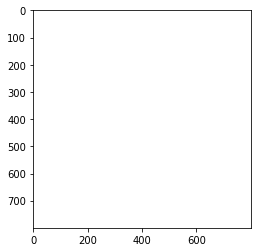

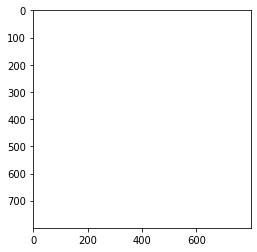

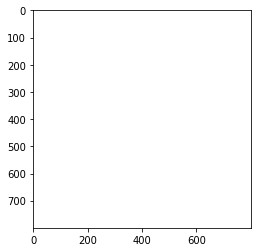

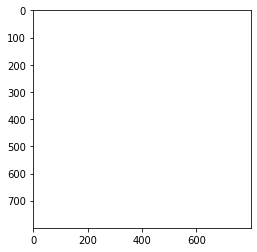

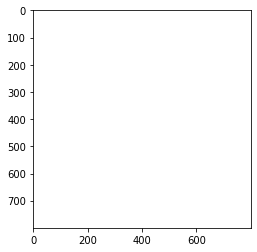

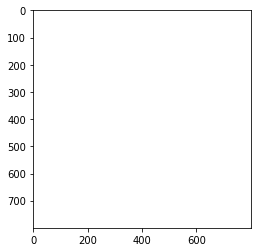

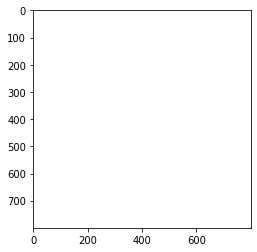

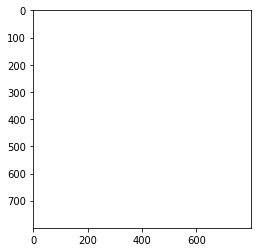

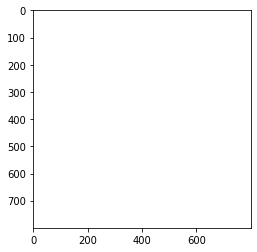

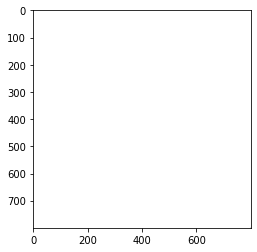

In [55]:

for i in range(iterations):
    plt.imshow(rec_images[i],cmap='gray')
    plt.show()

*** Sanity Check

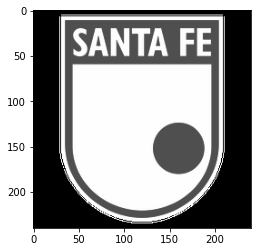

In [47]:
image = cv2.imread('SFE.png',flags=cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap='gray')

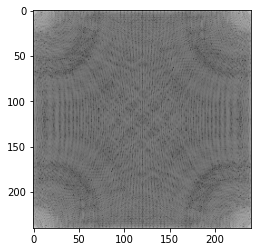

In [50]:
fft= np.fft.fft2(image)
#fshift = np.fft.fftshift(fft)
magnitude_spectrum = 20*np.log(np.abs(fft))
plt.imshow(magnitude_spectrum,cmap='gray')



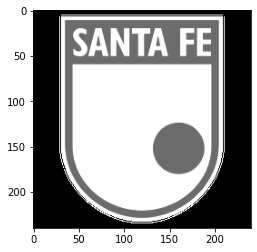

In [52]:
ifft = np.fft.ifft2(fft)
i_magnitude_spectrum = 20*np.log(np.abs(ifft))
plt.imshow(i_magnitude_spectrum,cmap='gray')